Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [52]:
# all imports needed for this sheet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [53]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

# If you're working locally:
else:
    DATA_PATH = '../data/'


In [54]:
df = pd.read_excel(DATA_PATH+'/Unit_2_project_data.xlsx')

In [55]:
exit_reasons = ['Rental by client with RRH or equivalent subsidy', 
                'Rental by client, no ongoing housing subsidy', 
                'Staying or living with family, permanent tenure', 
                'Rental by client, other ongoing housing subsidy',
                'Permanent housing (other than RRH) for formerly homeless persons', 
                'Staying or living with friends, permanent tenure', 
                'Owned by client, with ongoing housing subsidy', 
                'Rental by client, VASH housing Subsidy'
               ]

In [56]:
# pull all exit destinations from main data file and sum up the totals of each destination, 
# placing them into new df for calculations
exits = df['3.12 Exit Destination'].value_counts()

In [57]:
 # create target column (multiple types of exits to perm)
df['perm_leaver'] = df['3.12 Exit Destination'].isin(exit_reasons)

In [58]:
# base case
df['perm_leaver'].value_counts(normalize=True)

False    0.713086
True     0.286914
Name: perm_leaver, dtype: float64

In [59]:
# replace spaces with underscore
df.columns = df.columns.str.replace(' ', '_')

In [60]:
# see size of df prior to dropping empties
df.shape

(2025, 119)

In [61]:
# drop rows with no exit destination (current guests at time of report)
df = df.dropna(subset=['3.12_Exit_Destination'])

In [62]:
# shape of df after dropping current guests
df.shape

(1873, 119)

In [63]:
# verify no NaN in exit destination feature
df['3.12_Exit_Destination'].isna().value_counts()

False    1873
Name: 3.12_Exit_Destination, dtype: int64

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train = df

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['perm_leaver'], random_state=42)

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # drop any private information
    X = X.drop(columns=['3.1_FirstName', '3.1_LastName', '3.2_SocSecNo', 
                      '3.3_Birthdate', 'V5_Prior_Address'])
    
    # drop unusable columns
    X = X.drop(columns=['2.1_Organization_Name', '2.4_ProjectType',
                        'WorkSource_Referral_Most_Recent', 'YAHP_Referral_Most_Recent',
                        'SOAR_Enrollment_Determination_(Most_Recent)',
                        'R7_General_Health_Status', 'R8_Dental_Health_Status',
                        'R9_Mental_Health_Status', 'RRH_Date_Of_Move-In',
                        'RRH_In_Permanent_Housing', 'R10_Pregnancy_Due_Date',
                        'R10_Pregnancy_Status', 'R1_Referral_Source',
                        'R2_Date_Status_Determined', 'R2_Enroll_Status',
                        'R2_Reason_Why_No_Services_Funded', 'R2_Runaway_Youth',
                        'R3_Sexual_Orientation', '2.5_Utilization_Tracking_Method_(Invalid)',
                        '2.2_Project_Name', '2.6_Federal_Grant_Programs', '3.16_Client_Location',
                        '3.917_Stayed_Less_Than_90_Days', 
                        '3.917b_Stayed_in_Streets,_ES_or_SH_Night_Before', 
                        '3.917b_Stayed_Less_Than_7_Nights', '4.24_In_School_(Retired_Data_Element)',
                        'CaseChildren', 'ClientID', 'HEN-HP_Referral_Most_Recent',
                        'HEN-RRH_Referral_Most_Recent', 'Emergency_Shelter_|_Most_Recent_Enrollment',
                        'ProgramType', 'Days_Enrolled_Until_RRH_Date_of_Move-in',
                        'CurrentDate', 'Current_Age', 'Count_of_Bed_Nights_-_Entire_Episode',
                        'Bed_Nights_During_Report_Period'])
        
    # drop rows with no exit destination (current guests at time of report)
    X = X.dropna(subset=['3.12_Exit_Destination'])
    
    # remove columns to avoid data leakage
    X = X.drop(columns=['3.12_Exit_Destination', '5.9_Household_ID', '5.8_Personal_ID'])
    
    # Drop needless feature
    unusable_variance = ['Enrollment_Created_By', '4.24_Current_Status_(Retired_Data_Element)']
    X = X.drop(columns=unusable_variance)

    # Drop columns with timestamp
    timestamp_columns = ['3.10_Enroll_Date', '3.11_Exit_Date', 
                         'Date_of_Last_ES_Stay_(Beta)', 'Date_of_First_ES_Stay_(Beta)', 
                         'Prevention_|_Most_Recent_Enrollment', 'PSH_|_Most_Recent_Enrollment', 
                         'Transitional_Housing_|_Most_Recent_Enrollment', 'Coordinated_Entry_|_Most_Recent_Enrollment', 
                         'Street_Outreach_|_Most_Recent_Enrollment', 'RRH_|_Most_Recent_Enrollment', 
                         'SOAR_Eligibility_Determination_(Most_Recent)', 'Date_of_First_Contact_(Beta)',
                         'Date_of_Last_Contact_(Beta)', '4.13_Engagement_Date', '4.11_Domestic_Violence_-_When_it_Occurred',
                         '3.917_Homeless_Start_Date']
    X = X.drop(columns=timestamp_columns)
    
    # return the wrangled dataframe
    return X



In [76]:
train = wrangle(train)
val = wrangle(val)

In [ ]:
train.columns

In [77]:
# Arrange data into X features matrix and y target vector
target = 'perm_leaver'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]


In [78]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators=100
                       )
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.832


In [79]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    xgb.XGBClassifier(n_estimators=110, n_jobs=-1, num_parallel_tree=200,
                           random_state=42, max_depth=3
                       )
)
# Fit on Train
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['3.15_Relationship_to_HoH',
                                      '3.2_Social_Security_Quality',
                                      '3.3_Birthdate_Quality', '3.4_Race',
                                      '3.5_Ethnicity', '3.6_Gender',
                                      '3.7_Veteran_Status',
                                      '3.8_Disabling_Condition_at_Entry',
                                      '3.917_Living_Situation',
                                      '3.917_Length_of_Stay',
                                      '3.917_Times_Homeless_Last_3_Years',
                                      '3.917_Total_Months_Ho...
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, m

In [80]:
# Score on val
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7413333333333333


In [ ]:
# cross validation 

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', -scores)

In [ ]:
-scores.mean()

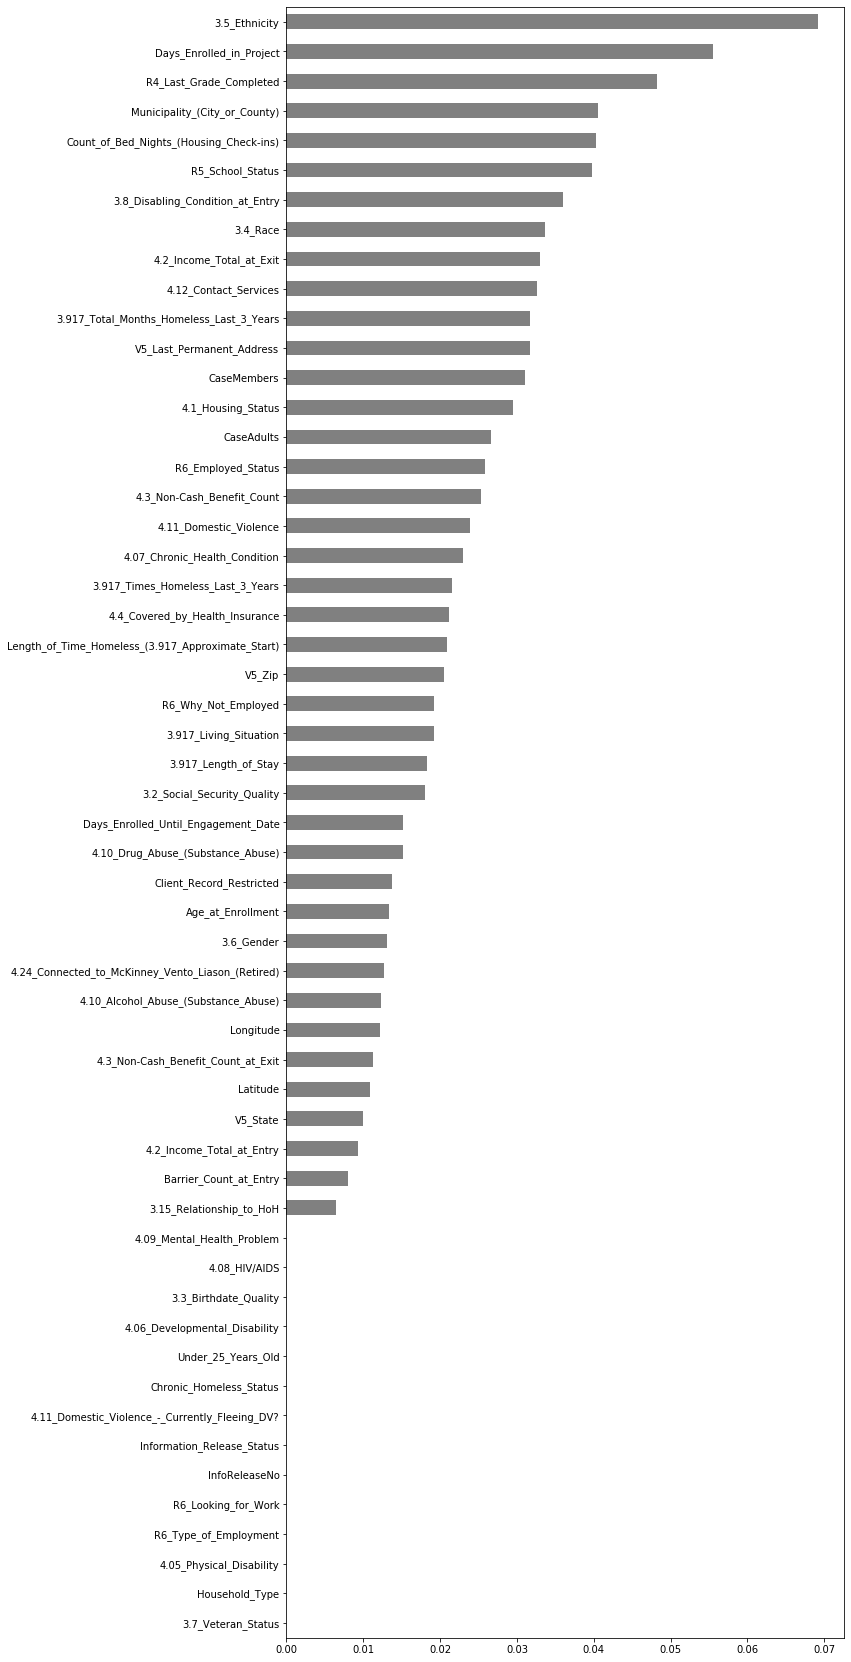

In [81]:
# get and plot feature importances

# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['xgbclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [83]:
df['4.1_Housing_Status'].value_counts()

Category 1 - Homeless                                      1071
Category 4 - Fleeing domestic violence                       20
Category 2 - At imminent risk of losing housing              16
At-risk of homelessness                                       4
Category 3 - Homeless only under other federal statutes       2
Client refused                                                2
Name: 4.1_Housing_Status, dtype: int64